---
title: "Joining Demographic Statistics onto a Dataset of Charity Donors with Python"
author: "Daniel J Smith"
date: "2024-04-08"
categories: [Python, Pandas, folium, scikit-learn, Emmanuel House]
title-block-banner: false
jupyter: python3
image: 'preview.png'
draft: false
description: "Learn how to read ONS lookup tables into Pandas to convert postcodes into local demographic statistics, such as population density and Index of Multiple Deprivation (IMD) score. Learn how to use `KNNImputer` from scikit-learn to fill missing values. See how these statistics correlate with donation history for a dataset of charity donors."
---

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import folium
from branca.colormap import LinearColormap
from sklearn.impute import KNNImputer

> - This post uses the dataset  `FakeIndividualConstituents.csv`, comprising of 100 randomly selected postcodes in Nottingham city and crudely constructed donation behaviours for the ficticious donors these postcodes represent.
>   
> - For the details of the construction of `FakeIndividualConstituents.csv` see [a previous blog post.](https://danieljamessmith.github.io/blog/posts/eh3/)
>
> - This post follows some of my voluntary data analysis  when studying a real dataset of donors to [Emmanuel House](https://www.emmanuelhouse.org.uk/) in Nottingham.

{{< downloadthis files/FakeIndividualConstituents.csv dname="FakeIndividualConstituents" label="Download `FakeIndividualConstituents.csv`" icon="database-fill-down" type="info" >}}

In [2]:
df = pd.read_csv('files/FakeIndividualConstituents.csv')

In [3]:
df.head()

,Postcode,NumberDonations,TotalDonated,AverageDonated,Newsletter
0,NG9 3WF,4,61,15.25,1
1,NG9 4WP,1,23,23.00,0
2,NG9 3EL,1,30,30.00,0
3,NG1 9FH,5,75,15.00,1
4,NG5 6QZ,1,15,15.00,0


In [4]:
df.describe()

,NumberDonations,TotalDonated,AverageDonated,Newsletter
count,100.000000,100.000000,100.00000,100.000000
mean,4.320000,250.150000,46.51950,0.500000
std,5.454828,1657.135245,212.23961,0.502519
min,1.000000,15.000000,15.00000,0.000000
25%,1.000000,30.000000,15.00000,0.000000
50%,2.000000,45.000000,15.19000,0.500000
75%,5.000000,92.000000,16.92500,1.000000
max,37.000000,16618.000000,2077.25000,1.000000


# GEOCODING

Lookup table connecting postcodes to the latitude/longitudes of their centres:

> [https://www.data.gov.uk/...](https://www.data.gov.uk/dataset/091feb1c-aea6-45c9-82bf-768a15c65307/open-postcode-geo)

See previous blog posts [(1)](https://danieljamessmith.github.io/blog/posts/eh1/)  [(2)](https://danieljamessmith.github.io/blog/posts/eh2/) for the details of this geocoding process.

In [5]:
post = pd.read_csv('LOOKUP_GEO/open_postcode_geo.csv', header=None, index_col=0)[[7, 8]]
post = post.rename(columns={7: 'Latitude', 8: 'Longitude'})
post.sample(5)

,Latitude,Longitude
0,,
EX19 8LW,50.916600,-4.060088
ML1 3LD,55.793773,-4.003318
NG17 8HS,53.112673,-1.268852
NG10 5AU,52.923366,-1.285042
WA1 3SS,53.399555,-2.570520


In [6]:
# Join Latitude and Longitude onto `df` using the 'Postcode' column
df = pd.merge(df, post, left_on='Postcode', right_index=True, how='left')

# Reorder the columns
df = df[['Postcode', 'Latitude', 'Longitude'] + [col for col in df.columns if col not in ['Postcode', 'Latitude', 'Longitude']]]

# Convert `Latitude` and `Longitude` columns from strings to floats
df['Latitude'] = pd.to_numeric(df['Latitude'], errors='coerce')
df['Longitude'] = pd.to_numeric(df['Longitude'], errors='coerce')

# Display number of null values in each column
df.isna().sum()

Postcode           0
Latitude           0
Longitude          0
NumberDonations    0
TotalDonated       0
AverageDonated     0
Newsletter         0
dtype: int64

In [7]:
df.head()

,Postcode,Latitude,Longitude,NumberDonations,TotalDonated,AverageDonated,Newsletter
0,NG9 3WF,52.930121,-1.198353,4,61,15.25,1
1,NG9 4WP,52.921587,-1.247504,1,23,23.00,0
2,NG9 3EL,52.938985,-1.239510,1,30,30.00,0
3,NG1 9FH,52.955008,-1.141045,5,75,15.00,1
4,NG5 6QZ,52.996670,-1.106307,1,15,15.00,0


# JOINING OAs

In order to join demographic statistics onto the dataframe, we first need to convert postcodes into various output areas (OAs). Specifically OA2021, LSOA2021, LSOA2011 and MSOA2011.

## What are Output Areas (OAs)?

> - Output Areas (OAs) are the smallest geographical unit for which census data is reported. In the UK, they were introduced for the 2001 Census and have been used since. They are designed to be of a similar population size, with each one containing at least 40 households and 100 individuals where possible. The aim is to provide a consistent base for reporting statistics over time.
>
> - Postcodes are a common way to identify locations in the UK, but they aren't designed for statistical analysis. They can vary in size and can change over time. On the other hand, Output Areas are specifically designed for statistical analysis and are more stable over time.
>
> - By translating postcodes into Output Areas, we can join our postcode-level data with other datasets that use Output Areas. 


## JOINING LSOA2021 and OA2021 ONTO POSTCODE

Lookup table for converting Postcode to LSOA2021 and OA2021:

> [https://geoportal.statistics.gov.uk/...](https://geoportal.statistics.gov.uk/datasets/ons::postcode-to-oa21-to-lsoa21-to-msoa21-to-ltla22-to-utla22-to-cauth22-nov-2023-lookup-for-the-uk/about)

In [8]:
# Read the lookup table and display 5 random rows
data = pd.read_csv('LOOKUP_GEO/PCD_OA21_LSOA21_MSOA21_LTLA22_UTLA22_CAUTH22_NOV23_UK_LU_v2.csv', low_memory=False)
data.sample(5)

,pcd7,pcd8,pcds,dointr,doterm,usertype,oa21cd,lsoa21cd,lsoa21nm,msoa21cd,msoa21nm,ltla22cd,ltla22nm,ltla22nmw,utla22cd,utla22nm,utla22nmw,cauth22cd,cauth22nm
2411384,TN4 0JY,TN4 0JY,TN4 0JY,198001,NaN,0,E00126111,E01024846,Tunbridge Wells 002C,E02005163,Tunbridge Wells 002,E07000116,Tunbridge Wells,NaN,E10000016,Kent,NaN,NaN,NaN
238683,BN3 7WA,BN3 7WA,BN3 7WA,200012,200212.0,1,E00085160,E01016873,Brighton and Hove 019D,E02003509,Brighton and Hove 019,E06000043,Brighton and Hove,NaN,E06000043,Brighton and Hove,NaN,NaN,NaN
1484466,ML3 6PJ,ML3 6PJ,ML3 6PJ,198001,NaN,0,S00131878,S01012725,NaN,S02002385,NaN,S12000029,South Lanarkshire,NaN,S12000029,South Lanarkshire,NaN,NaN,NaN
2320876,SW1X8DL,SW1X 8DL,SW1X 8DL,198001,NaN,0,E00190381,E01004691,Westminster 019E,E02000978,Westminster 019,E09000033,Westminster,NaN,E09000033,Westminster,NaN,NaN,NaN
2516422,W1J 5LF,W1J 5LF,W1J 5LF,200012,NaN,0,E00024109,E01004761,Westminster 018D,E02000977,Westminster 018,E09000033,Westminster,NaN,E09000033,Westminster,NaN,NaN,NaN


In [9]:
# Take and rename only the relevant columns ('pcds', 'oa21cd', 'lsoa21cd') of lookup table `data`
data = data[['pcds','oa21cd','lsoa21cd']].rename({'pcds':'Postcode', 
                                                  'oa21cd':'OA21', 
                                                  'lsoa21cd':'LSOA21'}, axis=1)

# Display 5 randomly chosen rows of lookup table
data.sample(5)

,Postcode,OA21,LSOA21
1217999,L37 3JL,E00035430,E01006990
2198583,SO1 3GD,E00086950,E01017216
123853,BA2 5JZ,E00072680,E01014389
206780,BL4 9RE,E00024606,E01004861
149180,BB7 9YF,E00128667,E01025351


In [10]:
# Joining 'OA21' and 'LSOA21' from the lookup table `data` onto donors `df` using the 'Postcode' column
df = df.merge(data, on='Postcode', how='left')

# Display number of null values in each column to see if successful
df.isna().sum()

Postcode           0
Latitude           0
Longitude          0
NumberDonations    0
TotalDonated       0
AverageDonated     0
Newsletter         0
OA21               0
LSOA21             0
dtype: int64

In [11]:
df.sample(5)

,Postcode,Latitude,Longitude,NumberDonations,TotalDonated,AverageDonated,Newsletter,OA21,LSOA21
72,NG2 7DL,52.945107,-1.135586,1,16,16.00,0,E00173532,E01033402
39,NG8 9QN,52.959883,-1.222125,9,138,15.33,1,E00069921,E01013860
37,NG8 3DJ,52.970564,-1.219671,4,60,15.00,1,E00069940,E01013867
97,NG9 2QA,52.930121,-1.198353,1,15,15.00,0,E00187586,E01028074
59,NG11 7AX,52.925360,-1.157251,1,539,539.00,1,E00070145,E01013901


## JOINING MSOA2011 ONTO POSTCODE

Lookup table for converting Postcode to MSOA2011: 

> [https://geoportal.statistics.gov.uk/...](https://geoportal.statistics.gov.uk/datasets/e7824b1475604212a2325cd373946235/about)

Please note that I have renamed my file to `pcd_to_oa11_msoa11_lsoa11.csv` from `PCD_OA_LSOA_MSOA_LAD_MAY22_UK_LU.csv` which was the name it had at download time.

In [12]:
# Read the lookup table and display 5 randomly chosen rows
data = pd.read_csv('LOOKUP_GEO/pcd_to_oa11_msoa11_lsoa11.csv', encoding='ISO-8859-1', low_memory=False)
data.sample(5)

,pcd7,pcd8,pcds,dointr,doterm,usertype,oa11cd,lsoa11cd,msoa11cd,ladcd,lsoa11nm,msoa11nm,ladnm,ladnmw
359020,BT8 6ZS,BT8 6ZS,BT8 6ZS,200912,NaN,0,N00001771,95II03S1,N99999999,N09000007,Cairnshill 1,(pseudo) Northern Ireland,Lisburn and Castlereagh,NaN
1700528,NW8 9QR,NW8 9QR,NW8 9QR,198001,NaN,0,E00023413,E01004648,E02000961,E09000033,Westminster 002B,Westminster 002,Westminster,NaN
945738,GL6 8WR,GL6 8WR,GL6 8WR,200212,200904.0,1,E00113923,E01022411,E02004656,E07000082,Stroud 006D,Stroud 006,Stroud,NaN
1056104,HU120NG,HU12 0NG,HU12 0NG,198001,NaN,0,E00066007,E01013079,E02002722,E06000011,East Riding of Yorkshire 039A,East Riding of Yorkshire 039,East Riding of Yorkshire,NaN
267517,BS161UY,BS16 1UY,BS16 1UY,201808,NaN,0,E00173035,E01033333,E02003106,E06000025,South Gloucestershire 017F,South Gloucestershire 017,South Gloucestershire,NaN


In [13]:
# Take and rename only the relevant columns ('pcds', 'msoa11cd') of lookup table `data`
data = data[['pcds', 'msoa11cd']].rename({'pcds':'Postcode',
                                          'msoa11cd':'MSOA11'}, axis=1)

# Display 5 randomly chosen rows
data.sample(5)

,Postcode,MSOA11
2292291,SW18 1BW,E02000932
939836,GL52 4JT,E02004670
2630775,WV12 5TE,E02002123
2617558,WS13 6TL,E02006150
663239,DH7 9RF,E02004307


In [14]:
# Joining 'MSOA11' from the lookup table `data` onto donors `df` using the 'Postcode' column:
df = df.merge(data, on='Postcode', how='left')
 
# Display number of null values in each column to see if successful:
df.isna().sum()

Postcode           0
Latitude           0
Longitude          0
NumberDonations    0
TotalDonated       0
AverageDonated     0
Newsletter         0
OA21               0
LSOA21             0
MSOA11             1
dtype: int64

# JOINING DEMOGRAPHIC STATISTICS ONTO OAs

## Understanding the Index of Multiple Deprivation (IMD) Score

The IMD Score is a measure of relative deprivation for small areas in the UK. It combines information from seven domains to produce an overall relative measure of deprivation. The higher the IMD Score, the more deprived an area is considered to be. Unlike the IMD Rank, which ranks areas in order, the IMD Score provides a measure of the absolute level of deprivation.

## Joining IMD2019 onto `df` by first coverting LSOA2021 to LSOA2011:

Lookup table coverting LSOA2021 to LSOA2011:

> [https://geoportal.statistics.gov.uk/...](https://geoportal.statistics.gov.uk/datasets/ons::lsoa-2011-to-lsoa-2021-to-local-authority-district-2022-lookup-for-england-and-wales-version-2-1/about)

Lookup table converting LSOA2011 to Index of Multiple Deprivation (IMD) 2019:

> [https://www.gov.uk/government/statistics/...](https://www.gov.uk/government/statistics/english-indices-of-deprivation-2019)

In [15]:
# Read the LSOA lookup data
lookup_data = pd.read_csv('LOOKUP_GEO/LSOA_(2011)_to_LSOA_(2021)_to_Local_Authority_District_(2022)_Lookup_for_England_and_Wales_(Version_2).csv')

# Take only the relevant columns of `lookup_data` and rename
lookup_data = lookup_data[['LSOA21CD','LSOA11CD']].rename({'LSOA21CD':'LSOA21', 
                                                           'LSOA11CD':'LSOA11'}, axis=1)

In [16]:
# Read the IMD data
imd_data = pd.read_csv('LOOKUP_STATS/File_7_-_All_IoD2019_Scores__Ranks__Deciles_and_Population_Denominators_3.csv')

# Take only the relevant columns of `imd_data` and rename
imd_data = imd_data[['LSOA code (2011)', 'Index of Multiple Deprivation (IMD) Score']].rename({'LSOA code (2011)':'LSOA11', 
                                                                                               'Index of Multiple Deprivation (IMD) Score':'IMD_Score'}, axis=1)

There is not a 1-to-1 correspondence between LSOA2011 and LSOA2021. We work around this by aggregating over the different LSOA2011 corresponding to each LSOA2021 and returning the mean of the IMD scores of each.

In [17]:
# Merge the IMD data with the lookup data
imd_data = imd_data.merge(lookup_data, on='LSOA11', how='left')

# Aggregate the IMD scores for each LSOA21 by taking the mean
imd_data = imd_data.groupby('LSOA21')['IMD_Score'].mean().reset_index()

In [18]:
# Joining 'IMD_Score' from the aggregated lookup table `imd_data` onto donors `df` using the 'LSOA21' column
df = df.merge(imd_data, on='LSOA21', how='left')

# Display number of null values in 'IMD_Score' column of `df` after the join
df['IMD_Score'].isna().sum()

2

### Using `KNNImputer` to fill missing IMD scores:

In [19]:
# Create a new dataframe with only the columns of interest
geo_data = df[['Latitude', 'Longitude', 'IMD_Score']]

# Create the imputer
imputer = KNNImputer(n_neighbors=5, weights='distance')

# Apply the imputer to the geo_data
geo_data_filled = imputer.fit_transform(geo_data)

# Convert the result back to a dataframe and preserve the original index
geo_data_filled = pd.DataFrame(geo_data_filled, columns=geo_data.columns, index=geo_data.index)

# Replace the original 'IMD_Score' column with the 'IMD_Score' with missing values filled
df['IMD_Score'] = geo_data_filled['IMD_Score']

In [20]:
df['IMD_Score'].isna().sum()

0

## Joining population density onto LSOA2021:

Lookup table connecting LSOA2021 to population density:

> [https://www.ons.gov.uk/peoplepopulationandcommunity/...](https://www.ons.gov.uk/peoplepopulationandcommunity/populationandmigration/populationestimates/datasets/lowersuperoutputareapopulationdensity)

Please note I used the 'Mid-2020: SAPE23DT11' edition of this dataset.

In [21]:
# Read the lookup table and display 5 randomly chosen rows
Pop_density_lookup = pd.read_csv('LOOKUP_STATS/sape23dt11mid2020lsoapopulationdensity 4(Sheet1).csv')
Pop_density_lookup.sample(5)

,LSOA Code,LSOA Name,Mid-2020 population,Area Sq Km,People per Sq Km
17470,E01029204,South Somerset 009C,"1,205",3.99,302
28309,E01000300,Barnet 019B,"1,763",0.17,"10,161"
30690,E01002662,Hounslow 017C,"2,658",0.24,"10,862"
23151,E01007102,Sefton 030D,"1,516",0.20,"7,535"
29991,E01032790,Hammersmith and Fulham 023F,"1,440",0.08,"18,228"


In [22]:
# Take and rename only the relevant columns ('LSOA Code', 'People per Sq Km') of lookup table `Pop_density_lookup`
Pop_density_lookup = Pop_density_lookup[['LSOA Code','People per Sq Km']].rename({'LSOA Code':'LSOA21', 
                                                                                  'People per Sq Km':'PopDensity'},axis=1)

# Display 5 randomly chosen rows
Pop_density_lookup.sample(5)

,LSOA21,PopDensity
18268,E01030319,"1,476"
10776,E01021912,194
1907,E01013840,"6,024"
15518,E01026885,55
7355,E01015276,"9,177"


In [23]:
# Joining 'PopDensity' from the lookup table `Pop_density_lookup` onto donors `df` using the 'LSOA21' column:
df = df.merge(Pop_density_lookup, on='LSOA21', how='left')

# Remove commas from joined population densities and convert to float type:
df['PopDensity'] = df['PopDensity'].str.replace(',', '').astype(float)

# Display number of null values in 'PopDensity' column:
df['PopDensity'].isna().sum()

19

### Using `KNNImputer` to fill missing population densities

In [24]:
# Create a new dataframe with only the columns of interest
pop_data = df[['Latitude', 'Longitude', 'PopDensity']]

# Create the imputer
imputer = KNNImputer(n_neighbors=5, weights='distance')

# Apply the imputer to the `pop_data`
pop_data_filled = imputer.fit_transform(pop_data)

# Convert the result back to a dataframe and preserve the original index
pop_data_filled = pd.DataFrame(pop_data_filled, columns=pop_data.columns, index=pop_data.index)

# Replace original 'PopDensity' column with the 'PopDensity' column with missing values filled
df['PopDensity'] = pop_data_filled['PopDensity']

In [25]:
df['PopDensity'].isna().sum()

0

## Joining Average Annual Income onto MSOA2011

Lookup table joining MSOA2011 to Average Annual Income:

> [https://www.ons.gov.uk/employmentandlabourmarket/...](https://www.ons.gov.uk/employmentandlabourmarket/peopleinwork/earningsandworkinghours/datasets/smallareaincomeestimatesformiddlelayersuperoutputareasenglandandwales)

Please note that my file `MSOA2011_to_Income.csv` is the 'Total Annual Income' sheet of the Financial year ending 2020 edition of this dataset.

In [26]:
# Read the lookup table and display 5 randomly chosen rows
income_lookup = pd.read_csv('LOOKUP_STATS/MSOA2011_to_Income.csv', encoding='ISO-8859-1', low_memory=False)
income_lookup.sample(5)

,MSOA code,MSOA name,Local authority code,Local authority name,Region code,Region name,Total annual income (£),Upper confidence limit (£),Lower confidence limit (£),Confidence interval (£)
6820,W02000030,Conwy 004,W06000003,Conwy,W92000004,Wales,"34,400","40,900","28,900","12,000"
2082,E02006827,Amber Valley 017,E07000032,Amber Valley,E12000004,East Midla,"35,500","42,100","29,800","12,300"
6309,E02003135,Plymouth 014,E06000026,Plymouth,E12000009,South West,"40,900","49,000","34,200","14,800"
1074,E02005327,Wyre 009,E07000128,Wyre,E12000002,North West,"42,300","50,000","35,700","14,300"
4319,E02000880,Tower Hamlets 017,E09000030,Tower Hamlets,E12000007,London,"50,500","59,800","42,600","17,200"


In [27]:
# Take and rename only the relevant columns ('MSOA code', 'Total annual income (£)') of lookup table `income_lookup`
income_lookup = income_lookup[['MSOA code','Total annual income (£)']].rename({'MSOA code':'MSOA11', 
                                                                               'Total annual income (£)':'AvgAreaIncome'}, axis=1)

# Display 5 randomly chosen rows
income_lookup.sample(5)

,MSOA11,AvgAreaIncome
717,E02001117,"46,900"
2198,E02005364,"42,500"
4561,E02000195,"59,500"
6000,E02006543,"45,500"
3514,E02004466,"51,700"


In [28]:
# Joining 'AvgAreaIncome' from the lookup table `income_lookup` onto donors `df` using the 'MSOA11' column:
df = df.merge(income_lookup, on='MSOA11', how='left')

# Removing commas from incomes and converting to float type:
df['AvgAreaIncome'] = df['AvgAreaIncome'].str.replace(',', '').astype(float)

# Display number of null values in 'AvgAreaIncome' column:
df['AvgAreaIncome'].isna().sum()

1

### Using `KNNImputer` to fill missing 'AvgAreaIncome' values

In [29]:
# Create a new dataframe `inc_data` with only the columns of interest
inc_data = df[['Latitude', 'Longitude', 'AvgAreaIncome']]

# Create the imputer
imputer = KNNImputer(n_neighbors=5, weights='distance')

# Apply the imputer to the `inc_data` dataframe
inc_data_filled = imputer.fit_transform(inc_data)

# Convert the result back to a dataframe and preserve the original index
inc_data_filled = pd.DataFrame(inc_data_filled, columns=inc_data.columns, index=inc_data.index)

# Replace original 'AvgAreaIncome' column with the corresponding column with missing values filled
df['AvgAreaIncome'] = inc_data_filled['AvgAreaIncome']

In [30]:
df['AvgAreaIncome'].isna().sum()

0

# VISUALISING RESULTS WITH FOLIUM

In [31]:
m = folium.Map(location=[52.9548, -1.1581], zoom_start=12)

colors = ['green', 'yellow', 'orange', 'red', 'purple']
linear_colormap = LinearColormap(colors=colors,
                                 vmin=df['PopDensity'].min(),
                                 vmax=df['PopDensity'].quantile(0.9))


for index, row in df.iterrows():    
    num_don = row['NumberDonations']
    total_don = row['TotalDonated']
    news = bool(row['Newsletter'])
    avg_don = row['AverageDonated']

    imd = row['IMD_Score']
    inc = row['AvgAreaIncome']
    pop = row['PopDensity']
    
    # Add popups when a marker clicked on
    popup_text = f'''
                    <div style="width: 250px; font-family: Arial; line-height: 1.2;">
                        <h4> Donation History: </h4>
                        <p style="margin: 0;"><b>Total Donated:</b> £{total_don:.2f}</p>
                        <p style="margin: 0;"><b>Number of Donations:</b> {num_don}</p>
                        <p style="margin: 0;"><b>Average Donation:</b> £{avg_don:.2f}</p>
                        <p style="margin: 0;"><b>Subscribed to Newsletter:</b> {"Yes" if news else "No"}</p>
                        <br>

                        <h4> Local Demographic Statistics: </h4>
                        <p style="margin: 0;"><b>Local Population Density:</b> {pop:.2f} ppl/km2</p>
                        <p style="margin: 0;"><b>Local IMD Score:</b> {imd:.2f}</p>
                        <p style="margin: 0;"><b>Local Average Income:</b> £{inc:.2f}</p>
                    </div>
                    '''

    color = linear_colormap(pop)
    
    marker = folium.CircleMarker(
        location=[row['Latitude'], row['Longitude']],
        radius=5,
        color=color, 
        fill=True,
        fill_color=color,
        fill_opacity=1,
        popup=popup_text
    ).add_to(m)
    

linear_colormap.add_to(m)
linear_colormap.caption = 'Population Density (Ppl per Sq Km)'

m

> - In the above map, the markers for each donor are coloured by that donors local population density. 
>
> - There is an clear trend of increasing population density as we move towards central Nottingham.

# Relationships between demographic statistics & donation history

## IMD Score

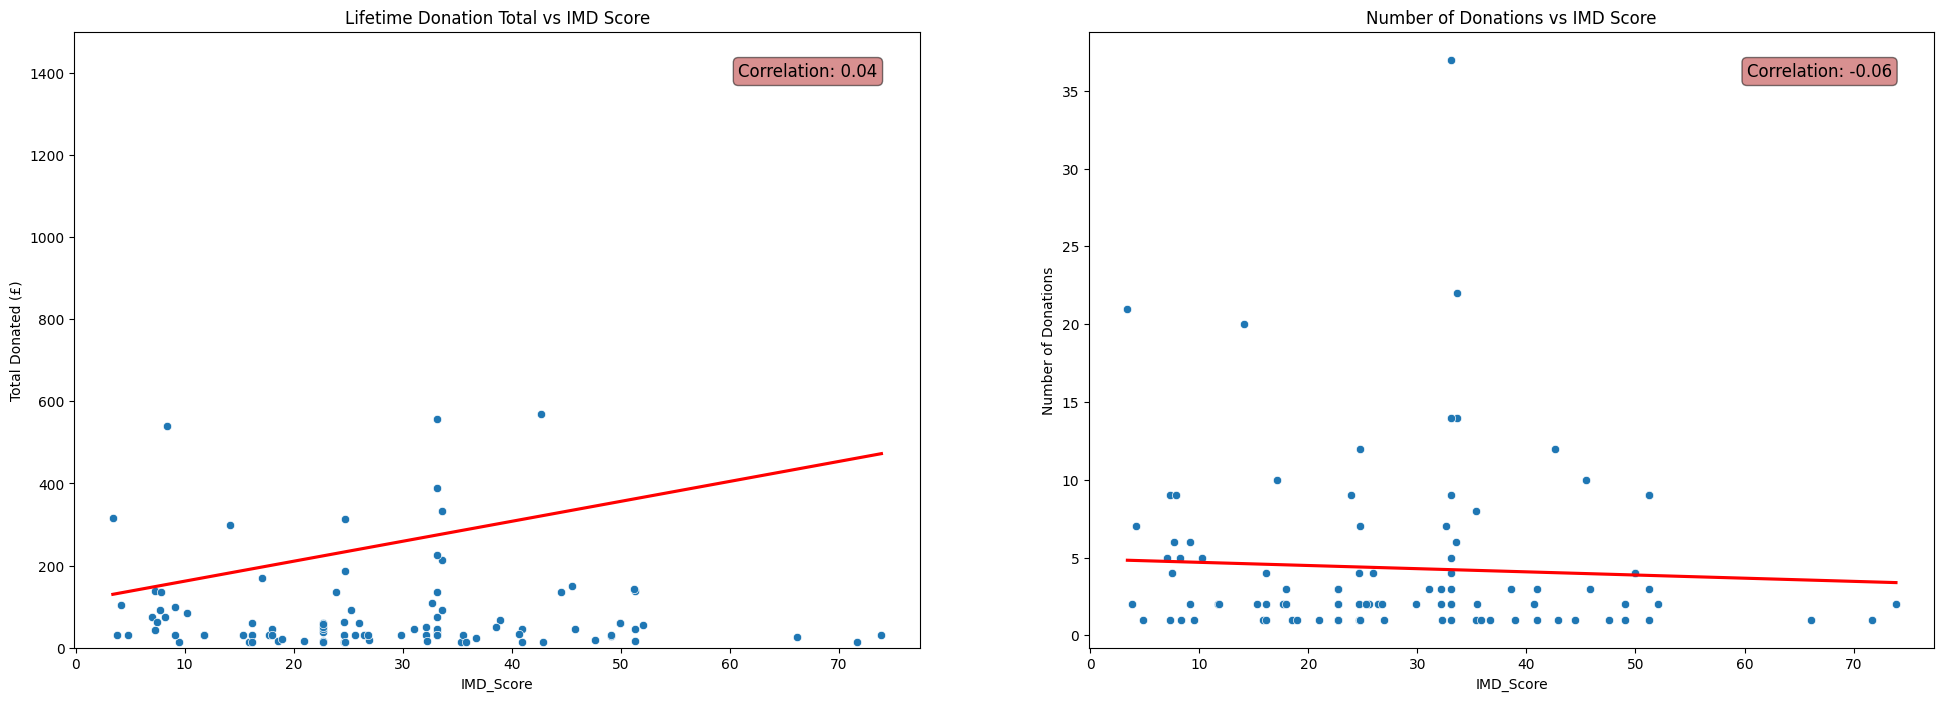

In [32]:
fig, axs = plt.subplots(1, 2, figsize=(24, 8))

# Total Donated vs IMD Score scatterplot
sns.scatterplot(x=df['IMD_Score'], y=df['TotalDonated'], ax=axs[0])
sns.regplot(x=df['IMD_Score'], y=df['TotalDonated'], scatter=False, color='red', ax=axs[0], ci=None)
corr = np.corrcoef(df['IMD_Score'], df['TotalDonated'])[0, 1]
axs[0].annotate(f'Correlation: {corr:.2f}', xy=(0.95, 0.95), xycoords='axes fraction',
                fontsize=12, ha='right', va='top', bbox=dict(boxstyle='round', fc='firebrick', alpha=0.5))
axs[0].set_ylim(0,1500)
axs[0].set_ylabel('Total Donated (£)')
axs[0].set_title('Lifetime Donation Total vs IMD Score')

# Number Donations vs IMD Score scatterplot
sns.scatterplot(x=df['IMD_Score'], y=df['NumberDonations'], ax=axs[1])
sns.regplot(x=df['IMD_Score'], y=df['NumberDonations'], scatter=False, color='red', ax=axs[1], ci=None)
corr = np.corrcoef(df['IMD_Score'], df['NumberDonations'])[0, 1]
axs[1].annotate(f'Correlation: {corr:.2f}', xy=(0.95, 0.95), xycoords='axes fraction',
                fontsize=12, ha='right', va='top', bbox=dict(boxstyle='round', fc='firebrick', alpha=0.5))
axs[1].set_ylabel('Number of Donations')
axs[1].set_title('Number of Donations vs IMD Score')

plt.show()

## Population Density

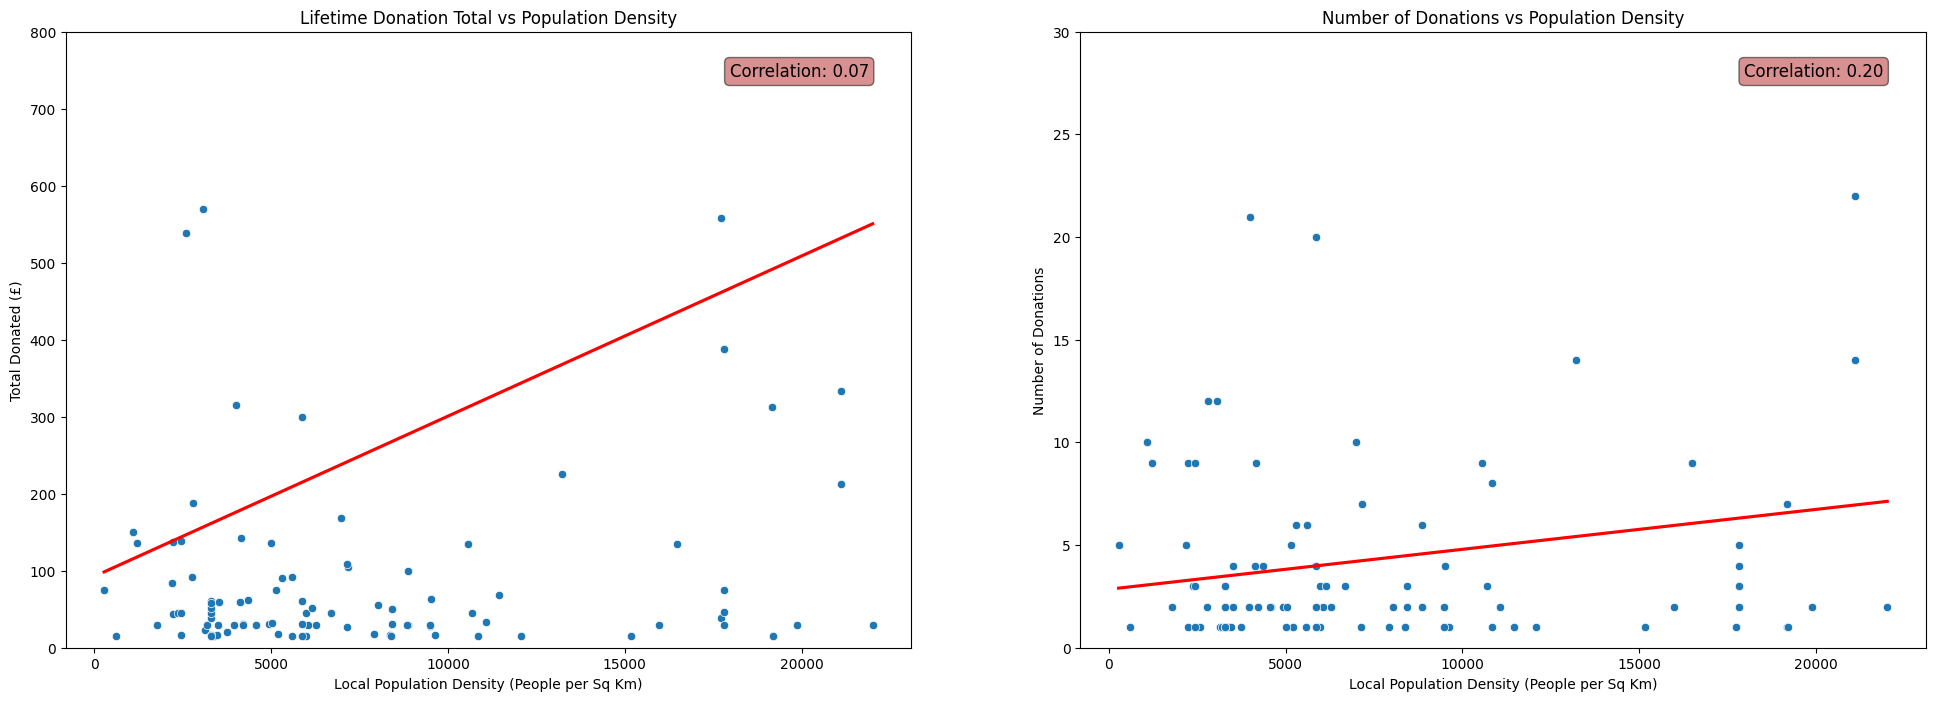

In [33]:
fig, axs = plt.subplots(1, 2, figsize=(24, 8))

# Total Donated vs Population Density scatterplot
sns.scatterplot(x=df['PopDensity'], y=df['TotalDonated'], ax=axs[0])
sns.regplot(x=df['PopDensity'], y=df['TotalDonated'], scatter=False, color='red', ax=axs[0], ci=None)
corr = np.corrcoef(df['PopDensity'], df['TotalDonated'])[0, 1]
axs[0].annotate(f'Correlation: {corr:.2f}', xy=(0.95, 0.95), xycoords='axes fraction',
                fontsize=12, ha='right', va='top', bbox=dict(boxstyle='round', fc='firebrick', alpha=0.5))
axs[0].set_ylim(0,800)
axs[0].set_ylabel('Total Donated (£)')
axs[0].set_xlabel('Local Population Density (People per Sq Km)')
axs[0].set_title('Lifetime Donation Total vs Population Density')

# Number Donations vs Population Density scatterplot
sns.scatterplot(x=df['PopDensity'], y=df['NumberDonations'], ax=axs[1])
sns.regplot(x=df['PopDensity'], y=df['NumberDonations'], scatter=False, color='red', ax=axs[1], ci=None)
corr = np.corrcoef(df['PopDensity'], df['NumberDonations'])[0, 1]
axs[1].annotate(f'Correlation: {corr:.2f}', xy=(0.95, 0.95), xycoords='axes fraction',
                fontsize=12, ha='right', va='top', bbox=dict(boxstyle='round', fc='firebrick', alpha=0.5))
axs[1].set_ylim(0,30)
axs[1].set_ylabel('Number of Donations')
axs[1].set_xlabel('Local Population Density (People per Sq Km)')
axs[1].set_title('Number of Donations vs Population Density')

plt.show()

## Average Income

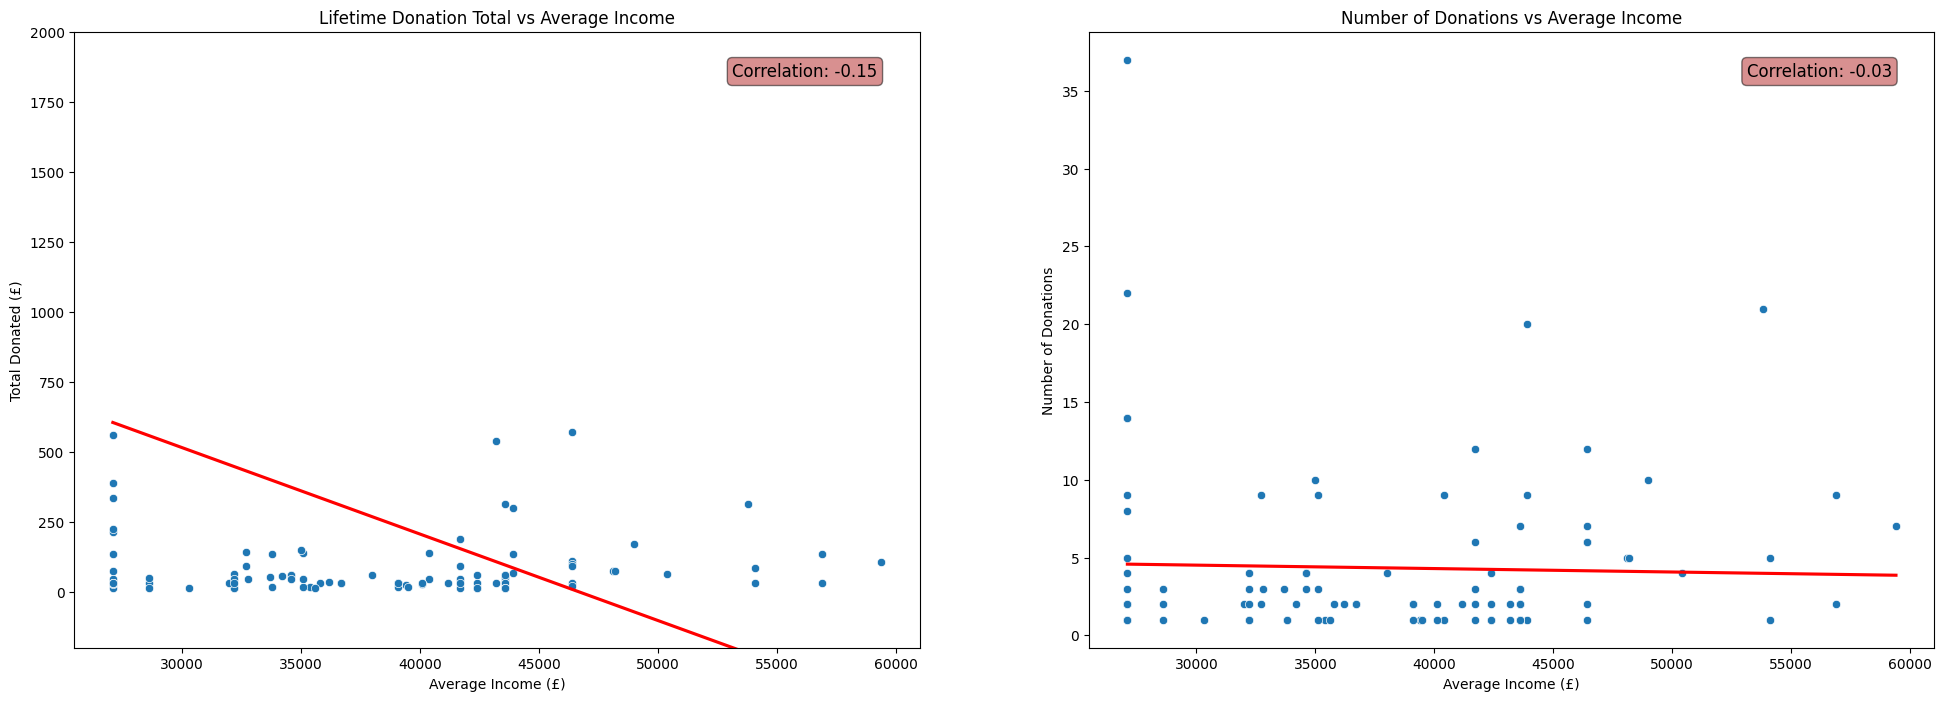

In [34]:
fig, axs = plt.subplots(1, 2, figsize=(24, 8))

# Total Donated vs Average Income scatterplot
sns.scatterplot(x=df['AvgAreaIncome'], y=df['TotalDonated'], ax=axs[0])
sns.regplot(x=df['AvgAreaIncome'], y=df['TotalDonated'], scatter=False, color='red', ax=axs[0], ci=None)
corr = np.corrcoef(df['AvgAreaIncome'], df['TotalDonated'])[0, 1]
axs[0].annotate(f'Correlation: {corr:.2f}', xy=(0.95, 0.95), xycoords='axes fraction',
                fontsize=12, ha='right', va='top', bbox=dict(boxstyle='round', fc='firebrick', alpha=0.5))
axs[0].set_ylim(-200,2000)
axs[0].set_ylabel('Total Donated (£)')
axs[0].set_xlabel('Average Income (£)')
axs[0].set_title('Lifetime Donation Total vs Average Income')

# Number Donations vs Average Income scatterplot
sns.scatterplot(x=df['AvgAreaIncome'], y=df['NumberDonations'], ax=axs[1])
sns.regplot(x=df['AvgAreaIncome'], y=df['NumberDonations'], scatter=False, color='red', ax=axs[1], ci=None)
corr = np.corrcoef(df['AvgAreaIncome'], df['NumberDonations'])[0, 1]
axs[1].annotate(f'Correlation: {corr:.2f}', xy=(0.95, 0.95), xycoords='axes fraction',
                fontsize=12, ha='right', va='top', bbox=dict(boxstyle='round', fc='firebrick', alpha=0.5))
#axs[1].set_ylim(0,30)
axs[1].set_ylabel('Number of Donations')
axs[1].set_xlabel('Average Income (£)')
axs[1].set_title('Number of Donations vs Average Income')

plt.show()

# Remarks

> - It may be tempting to write off the negligble correlations shown in the above plots as facets of the fact that the donors in `FakeIndividualConstituents.csv` have randomly selected postcodes and crudely contructed donation histories.
>
> - ([See my previous post](https://danieljamessmith.github.io/blog/posts/eh2/) for the details of the contruction of this dataset.)
>
> - This means we perhaps shouldn't expect to see any non-negligible correlations, due to the random nature of the process used to produce the fake data that did not take into account properties like population density.
>
> - However, the patterns shown in the real data were very similar. In fact, the correlations between each of IMD Score, Population Density and Average Income with Number of Donations and Total Donated were even closer to zero for the dataset of real donors to Emmanuel House than for the fake dataset used above.
>
> - This initially suprised me. I thoroughly expected for the data to display a clear relationship between the social deprivation of the area in which donors live and their donation patterns. In reality this was not reflected in the data at all.
>
> - It may be that the relationship between these statistics and a donor's behaviour is far more complicated than linear, and thus is not well described by the correlation coefficient.
>
> - On the other hand, it may be that there is no interpretable relationship between a donors demographic statistics and their donation behaviour. 